### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../propensALLTheory/'
p1 = 'propensALLTheory/'

base_path = '../results/'+p1

treated = pd.read_pickle(p+'treated2.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'matched.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 282 ms, sys: 148 ms, total: 430 ms
Wall time: 501 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
treated.MYR.min()

201710

In [6]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 202001
    month_filter_upper = 202101
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [7]:
filter_cols =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 0

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [8]:

path_tabs = base_path+'tables/survival/'
path_figs = base_path+'figures/kaplan/'
path_figs2 = base_path+'figures/cox/' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [9]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E', 'Treatment']

summary_names = ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness', 'Treatment']

### Diabetes

In [10]:
%%time
after = 0
grace = 0 # if grace is setted after is setted 0 by default
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12.1 s, sys: 50.7 ms, total: 12.1 s
Wall time: 12.1 s


In [11]:
survTr.head()

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
0  2602482  24  0      0     0.0     0.0        0               81          0   
1  2603072  19  0      0     0.0     0.0        1               82        101   
2  2606370  10  0      0     0.0     0.0        1               82         23   
3  2608221   1  1      0     0.0     0.0        0               81        442   
4  2619378   1  1      0     0.0     0.0        1               78        399   

   ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  MEDICAID_LOB  \
0       0.0  ...       0      0.0      0.0     0    1         0    Commercial   
1       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
2       0.0  ...       0      0.0      0.0     1    1         0      Medicare   
3       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
4       0.0  ...       0      0.0      0.0     0    1         1      Medicare   

      MYR  PREGNANCY  Treatment  
0  201908        0.0          1  
1  202001        0.0          1  
2  202010        0.0          1  
3  202010        0.0          1  
4  201910        0.0          1  

[5 rows x 94 columns]

In [12]:
survTr.shape, survCo.shape

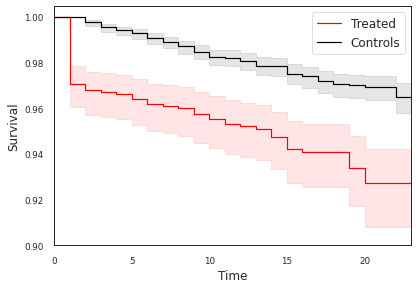

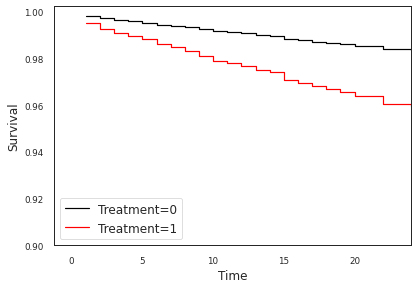

In [13]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
ylimDB = [0.9]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title, ylim = ylimDB)

In [14]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       41.429166  1.222202e-10  32.929798

In [15]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               2.149           0.544        3.948    0.000
Total Cost                        0.043           0.028        1.531    0.126
Gender                            0.350           0.142        2.460    0.014
Tobacco Use                       0.217           0.203        1.068    0.285
Pressure                         -0.974           1.012       -0.962    0.336
Obesity                           0.715           0.140        5.099    0.000
Hypertension                      0.053           0.159        0.335    0.738
Hypothyroid                       0.014           0.208        0.065    0.948
Disease Count                     1.457           0.670        2.173    0.030
Acute Care 2 Months               0.163           0.325        0.501    0.616
Acute Care 6 Months               0.150           0.857        0.174    0.861
Inpatient Visits 6 Months        -0.293           0.761       -0.385    0.700
Emergency Vistits 6 Months       -0.034           0.811       -0.041    0.967
Line of Bussiness                -0.651           0.192       -3.391    0.001
Treatment                         0.923           0.144        6.414    0.000

### ER

data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [16]:
treated.columns

Index(['PERS_ID', 'MYR', 'MBR_GNDR', 'AGE_AT_MIDMONTH', 'ALLOW_AMT',
       'MEDICAID_LOB', 'ALLOW_ER', 'ALLOW_IP', 'CC_ADHD', 'CC_ALZHEIMER',
       'CC_ALZHEIMER_PLUS', 'CC_AMI', 'CC_ANEMIA', 'CC_ANXIETY_DISORDER',
       'CC_ARTHRITIS', 'CC_ASTHMA', 'CC_ATRIAL_FIB', 'CC_AUTISM', 'CC_BIPOLAR',
       'CC_BPH', 'CC_BREAST_CANCER', 'CC_CATARACT', 'CC_CEREBRAL_PALSY',
       'CC_CHRONIC_KIDNEY', 'CC_COLORECTAL_CANCER', 'CC_COPD',
       'CC_CYSTIC_FIBROSIS', 'CC_DEPRESSION', 'CC_DEPRESSIVE_DISORDERS',
       'CC_DEVELOP_DELAYS', 'CC_DIABETES', 'CC_DISAB_DX_CNT', 'CC_DX_CNT',
       'CC_ENDOMETRIAL_CANCER', 'CC_EPILEPSY', 'CC_FIBROMYALGIA',
       'CC_GLAUCOMA', 'CC_HEARING_IMPAIR', 'CC_HEART_FAILURE',
       'CC_HEPATITIS_A', 'CC_HEPATITIS_B_ACUTE', 'CC_HEPATITIS_B_CHRONIC',
       'CC_HEPATITIS_C_ACUTE', 'CC_HEPATITIS_C_CHRONIC',
       'CC_HEPATITIS_C_UNSPECIFIED', 'CC_HEPATITIS_D', 'CC_HEPATITIS_E',
       'CC_HEPATITIS_GEN', 'CC_HIP_FRACTURE', 'CC_HYPERLIPIDEMIA',
       'CC_HYPERTE

In [17]:
%%time
onset = 'ER_BIN'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, 
                                                 grace = grace, 
                                                 onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])

survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset,
                                                  grace = grace).reset_index(drop = True).dropna(axis = 0,subset = ['PERS_ID'])


CPU times: user 12.1 s, sys: 46.9 ms, total: 12.1 s
Wall time: 12.1 s


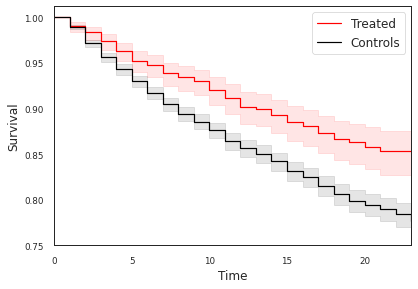

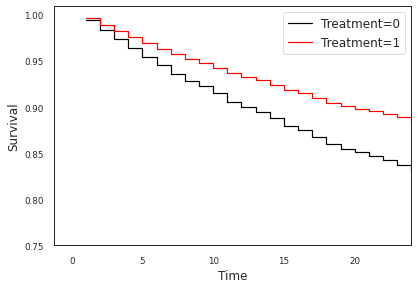

In [18]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
ylimER = [0.75]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, path_figs2=path_figs2, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimER)

In [19]:
lrsumm

test_statistic             p   -log2(p)
Emergency Visits       23.974104  9.764017e-07  19.966022

In [20]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -1.058           0.216       -4.904    0.000
Total Cost                        0.042           0.012        3.501    0.000
Gender                           -0.050           0.067       -0.745    0.456
Tobacco Use                       0.145           0.085        1.714    0.087
Pressure                         -0.266           0.363       -0.733    0.464
Obesity                          -0.099           0.062       -1.579    0.114
Hypertension                      0.123           0.075        1.637    0.102
Hypothyroid                      -0.228           0.101       -2.251    0.024
Disease Count                     2.116           0.302        7.011    0.000
Acute Care 2 Months               1.105           0.115        9.618    0.000
Acute Care 6 Months              -0.038           0.294       -0.128    0.898
Inpatient Visits 6 Months        -0.318           0.245       -1.295    0.195
Emergency Vistits 6 Months        0.677           0.277        2.441    0.015
Line of Bussiness                -0.578           0.075       -7.716    0.000
Treatment                        -0.408           0.087       -4.664    0.000

### IP

data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [21]:
%%time
onset = 'IP_BIN'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12.1 s, sys: 36 ms, total: 12.2 s
Wall time: 12.2 s


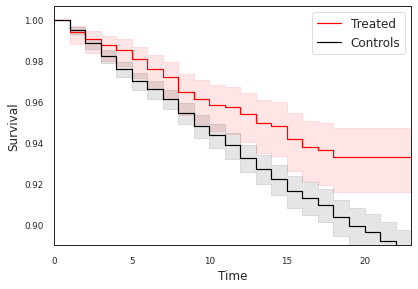

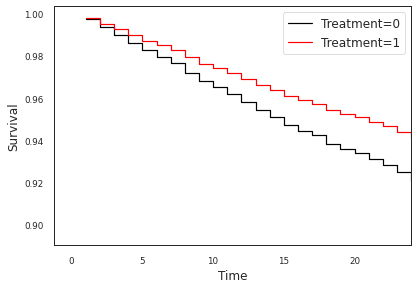

In [22]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
ylimIP =  [0.89]

lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimIP)

In [23]:
lrsumm

test_statistic         p  -log2(p)
Inpatient Visits       10.544995  0.001165  9.745415

In [24]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               1.281           0.327        3.921    0.000
Total Cost                        0.096           0.019        5.033    0.000
Gender                            0.095           0.091        1.038    0.299
Tobacco Use                       0.055           0.123        0.447    0.655
Pressure                          0.225           0.281        0.799    0.424
Obesity                          -0.030           0.088       -0.343    0.732
Hypertension                      0.122           0.102        1.196    0.232
Hypothyroid                      -0.123           0.127       -0.972    0.331
Disease Count                     2.777           0.356        7.796    0.000
Acute Care 2 Months               0.933           0.148        6.288    0.000
Acute Care 6 Months              -0.216           0.312       -0.692    0.489
Inpatient Visits 6 Months         0.964           0.281        3.433    0.001
Emergency Vistits 6 Months        0.159           0.286        0.556    0.578
Line of Bussiness                -0.230           0.124       -1.858    0.063
Treatment                        -0.308           0.124       -2.489    0.013

### Acute Care IP OR ER

data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [25]:
%%time
onset = 'ACUTE'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12 s, sys: 50.1 ms, total: 12.1 s
Wall time: 12.1 s


In [26]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
4     2619378   3  1     0.0     0.0        1               78        399   
5     2621187  11  1     0.0     0.0        2               78      13007   
6     2623521  28  1     0.0     0.0        0               77          0   
16    2651688   4  1     0.0     0.0        0               74        179   
26    2668219   5  1     0.0     0.0        0               71        346   
...       ...  .. ..     ...     ...      ...              ...        ...   
1330  4390059   4  1     0.0     0.0        0               47          2   
1334  4398341  11  1     0.0     0.0        0               66          0   
1337  5001236  16  1     0.0     0.0        0               60        374   
1342  5003200   1  1     1.0     1.0        1               55       3137   
1348  5014675   3  1     0.0     0.0        1               26        409   

      ALLOW_ER  ALLOW_IP  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  \
4          0.0       0.0  ...       0      0.0      0.0     0    1         1   
5          0.0       0.0  ...       0      0.0      0.0     0    1         1   
6          0.0       0.0  ...       0      0.0      0.0     0    1         0   
16         0.0       0.0  ...       0      0.0      0.0     0    1         1   
26         0.0       0.0  ...       0      0.0      0.0     0    1         0   
...        ...       ...  ...     ...      ...      ...   ...  ...       ...   
1330       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1334       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1337       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1342    1298.0       0.0  ...       0      0.0      0.0     0    1         0   
1348       0.0       0.0  ...       0      0.0      0.0     0    1         0   

      MEDICAID_LOB     MYR  PREGNANCY  Treatment  
4         Medicare  201910        0.0          1  
5         Medicare  202001        0.0          1  
6         Medicare  201903        0.0          1  
16        Medicare  202011        0.0          1  
26        Medicare  201911        0.0          1  
...            ...     ...        ...        ...  
1330    Commercial  202002        0.0          1  
1334      Medicare  202005        0.0          1  
1337    Commercial  202002        0.0          1  
1342    Commercial  202005        0.0          1  
1348    Commercial  202010        0.0          1  

[212 rows x 94 columns]

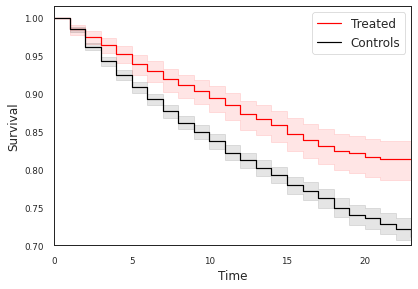

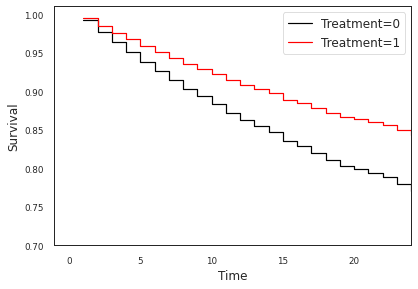

In [27]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
ylim = [0.7]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylim)

In [28]:
lrsumm

test_statistic             p   -log2(p)
Acute Care       29.531582  5.501294e-08  24.115654

In [29]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.466           0.192       -2.425    0.015
Total Cost                        0.068           0.011        6.185    0.000
Gender                            0.006           0.058        0.104    0.917
Tobacco Use                       0.081           0.076        1.061    0.289
Pressure                          0.106           0.246        0.430    0.667
Obesity                          -0.076           0.055       -1.394    0.163
Hypertension                      0.087           0.065        1.331    0.183
Hypothyroid                      -0.165           0.086       -1.920    0.055
Disease Count                     2.148           0.261        8.245    0.000
Acute Care 2 Months               1.271           0.099       12.894    0.000
Acute Care 6 Months               0.418           0.250        1.673    0.094
Inpatient Visits 6 Months        -0.069           0.222       -0.310    0.756
Emergency Vistits 6 Months        0.104           0.235        0.443    0.658
Line of Bussiness                -0.450           0.068       -6.595    0.000
Treatment                        -0.428           0.076       -5.628    0.000

### Acute Care  diff and diff calculation

In [30]:
%%time
from utils import findDate, filter_first_date
from data_functions import make_date_to_MYR

pmpm = pd.read_pickle('../Pre_Matching_DATA/'+'pmpm.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls_all = pd.read_pickle(p+'controls_all.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 12.5 s, sys: 18.5 s, total: 31 s
Wall time: 31.9 s


In [31]:
%%time
tr = treated.copy().drop(columns = ['Treatment'], axis = 1)
cr = controls.copy().drop(columns = ['Treatment'], axis = 1)

treated2 = (filter_first_date(findDate(tr.copy(), pmpm.copy(), 5))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls2 = (filter_first_date(findDate(cr.copy(), controls_all.copy(), 5))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

try:
    controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    controls2 = controls2
try:
    treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    treated2 = treated2
treated2['Treatment'] = 1
controls2['Treatment'] = 0
data2 = [treated2,  controls2]
#for d in data2:
#    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

CPU times: user 26.8 s, sys: 2.4 s, total: 29.2 s
Wall time: 29.2 s


In [32]:
treated2.shape, controls2.shape

In [33]:
treated.PERS_ID.unique().shape, controls.PERS_ID.unique().shape

In [34]:
treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape

In [35]:
%%time
times = [0]
onset = 'ACUTE'


survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
# curves.append((survTr, survCo))

CPU times: user 12.4 s, sys: 109 ms, total: 12.5 s
Wall time: 12.5 s


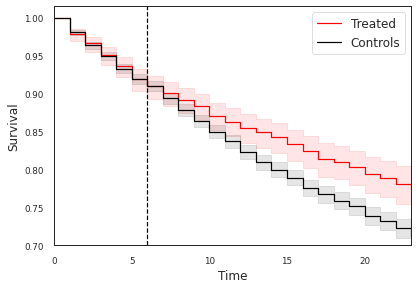

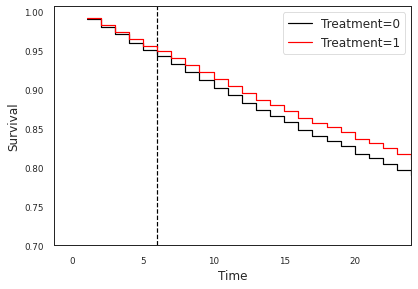

In [36]:
fittedDD, rmstAcuteDD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                      model = model, model_type = model_type,
                      model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                     log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care_dd'
ylim = [0.7]
lrsummDD, ax1, ax2, summDD = make_results(fittedDD, survTr, survCo, path_tabs = path_tabs, 
                                  path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                  model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                  filter_cols = filter_cols2, summary_names = summary_names,
                                 log_normalize = log_normalize, normalize = normalize,
                                 kaplan_plot_params=kaplan_plot_params,
                                  timeline = timeline,
                                  outcome_title = 0, ylim = ylim, ver_line = True, ver_line_val = 6)

In [37]:
lrsummDD

test_statistic         p   -log2(p)
Acute Care_dd       16.897869  0.000039  14.629768

In [38]:
summDD

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.439           0.174       -2.525    0.012
Total Cost                        0.056           0.010        5.832    0.000
Gender                           -0.056           0.054       -1.048    0.295
Tobacco Use                      -0.005           0.072       -0.068    0.946
Pressure                          0.585           0.215        2.727    0.006
Obesity                          -0.079           0.051       -1.567    0.117
Hypertension                      0.150           0.059        2.540    0.011
Hypothyroid                       0.015           0.077        0.194    0.846
Disease Count                     1.865           0.200        9.333    0.000
Acute Care 2 Months               1.155           0.086       13.452    0.000
Acute Care 6 Months               0.697           0.177        3.947    0.000
Inpatient Visits 6 Months        -0.500           0.157       -3.186    0.001
Emergency Vistits 6 Months       -0.139           0.170       -0.815    0.415
Line of Bussiness                -0.632           0.061      -10.293    0.000
Treatment                        -0.121           0.066       -1.830    0.067

### Load all Log Rank Sums in a matrix

In [39]:
from pathlib import Path
pp = Path(path_tabs)

df2 = None
for i, ff in enumerate(pp.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)

df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['LogRank Statistic', 'LogRank Test P-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care', 'Acute Care DD']
for month, i in zip([6,12,18,24], [0,1,2,3]):
    df2['RMST Difference After '+ str(month)+' Months'] = np.array([rmstD[i], rmstER[i], rmstIP[i], rmstAcute[i], rmstAcuteDD[i]])
df2.to_csv(path_tabs+'all_logrank.csv')

In [40]:
df2.round(2)

LogRank Statistic  LogRank Test P-value  \
Diabetes                      41.43                   0.0   
Emergency Visits              23.97                   0.0   
Inpatient Vistis              10.54                   0.0   
Acute Care                    29.53                   0.0   
Acute Care DD                 16.90                   0.0   

                  RMST Difference After 6 Months  \
Diabetes                                   -0.14   
Emergency Visits                            0.07   
Inpatient Vistis                            0.03   
Acute Care                                  0.09   
Acute Care DD                               0.01   

                  RMST Difference After 12 Months  \
Diabetes                                    -0.31   
Emergency Visits                             0.31   
Inpatient Vistis                             0.10   
Acute Care                                   0.40   
Acute Care DD                                0.09   

                  RMST Difference After 18 Months  \
Diabetes                                    -0.50   
Emergency Visits                             0.63   
Inpatient Vistis                             0.25   
Acute Care                                   0.79   
Acute Care DD                                0.34   

                  RMST Difference After 24 Months  
Diabetes                                    -0.72  
Emergency Visits                             1.02  
Inpatient Vistis                             0.49  
Acute Care                                   1.31  
Acute Care DD                                0.68